In [1]:
import sys, os, argparse
import time
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
from numpy import ma 

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from pylab import imshow,cm

#Import packages for interpolating
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator as LNDI

# Import package for parallel computing
from joblib import Parallel, delayed


In [2]:

"""
# Create the parser
parser = argparse.ArgumentParser(description="Process some parameters for clustering.")
# Add required arguments
parser.add_argument("Ncores", type=int, help="Number of CPU's")
parser.add_argument("velocities_file_path", type=str, help="Path to the file")
parser.add_argument("parent_directory", type=str, help="Parent directory")
parser.add_argument("results_directory", type=str, help="Results directory")
parser.add_argument("ic_resolution", type=float, help="Lat and lon resolution for the IC ")
parser.add_argument("dt", type=float, help="Time step size for Runge Kutta")
parser.add_argument("DT", type=float, help="Time step size for Fmap")
# Parse the arguments
args = parser.parse_args()

Ncores = args.Ncores
velocities_file_path = args.velocities_file_path
parent_directory = args.parent_directory
results_directory = args.results_directory
ic_resolution = args.ic_resolution
dt = args.dt
DT = args.DT"
"""


'\n# Create the parser\nparser = argparse.ArgumentParser(description="Process some parameters for clustering.")\n# Add required arguments\nparser.add_argument("Ncores", type=int, help="Number of CPU\'s")\nparser.add_argument("velocities_file_path", type=str, help="Path to the file")\nparser.add_argument("parent_directory", type=str, help="Parent directory")\nparser.add_argument("results_directory", type=str, help="Results directory")\nparser.add_argument("ic_resolution", type=float, help="Lat and lon resolution for the IC ")\nparser.add_argument("dt", type=float, help="Time step size for Runge Kutta")\nparser.add_argument("DT", type=float, help="Time step size for Fmap")\n# Parse the arguments\nargs = parser.parse_args()\n\nNcores = args.Ncores\nvelocities_file_path = args.velocities_file_path\nparent_directory = args.parent_directory\nresults_directory = args.results_directory\nic_resolution = args.ic_resolution\ndt = args.dt\nDT = args.DT"\n'

In [3]:
Ncores=32
year="2010"
season="AMJ"
ic_resolution=0.5
dt=0.0025
DT=0.1

parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
# Format DT and dt to four decimal places
formatted_DT = f"{DT:.4f}"
formatted_dt = f"{dt:.4f}"
# Construct the filename
filename = f"OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}.nc"
# Construct the directory path
directory = f"/cluster/projects/nn9970k/lluisa/NextSIM/rotated_ice_velocities/seas/{season}/"
# Construct the full path to the velocities file
velocities_file_path = os.path.join(directory, filename)

# Construct the Fmap_params string
Fmap_params = f"{year}_{season}_"
Fmap_params += f"ic{ic_resolution}_"
Fmap_params += f"dt{formatted_dt}_"
Fmap_params += f"DT{formatted_DT}"
# Construct the Fmap results directory path
results_directory = os.path.join(directory, "Fmap", Fmap_params)




In [4]:

timemod = int(DT/dt) 
latitude_resolution = 0.15
longitude_resolution = 0.15


# Create the results directory if it doesn't exist
try:
    os.makedirs(results_directory, exist_ok=True)
    print(f"Directory '{results_directory}' is ready.")
except Exception as e:
    print(f"An error occurred while creating the directory: {e}")
    sys.exit(1)


# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_construction")
sys.path.append(parent_directory+"/subfunctions/trajectory_advection")
sys.path.append(parent_directory+"/subfunctions/Parallelisation")
sys.path.append(parent_directory+"/utils")

# Import linear interpolation function for unsteady flow field with irregular grid
from Interpolant import interpolant_unsteady
from Interpolant import regrid_unsteady , generate_mask_interpolator , generate_velocity_interpolants
# Import function to compute flow map/particle trajectories
from integration_dFdt import integration_dFdt
from outflow_detector import outflow_detector
from initialize_ic import initialize_ic
from regular_regrid import regular_grid_interpolation, regular_grid_interpolation_scalar
from trajectory_advection import trajectory_advection
#Parallelisation folder
from parallelised_functions import split3D , split 
from NetCDF_generator import save_velocities_to_netCDF, save_velocities_sicsit_to_netCDF, generate_regrided

#########################################################################################

# Interpolate to a regular grid to then generate the interpolator objects.
reg_vel_file_path = velocities_file_path[:-3]+'_regrided.nc'


# Check if the files exist and save them if they don't
if not os.path.exists(reg_vel_file_path):
    print("The velocity has not been regrided yet")
    generate_regrided(reg_vel_file_path,velocities_file_path,latitude_resolution,longitude_resolution,Ncores)

else:
    print("The velocity has allready been regrided. We read the files")
   
# Read dataset
print("Reading the input data")
dataset = nc.Dataset(reg_vel_file_path, mode='r')
#from m/s to m/day
interpolated_siu = dataset.variables['vlon'][:,:,:]
interpolated_siv = dataset.variables['vlat'][:,:,:]
interpolated_siu = np.transpose(interpolated_siu, axes=(1, 2, 0))
interpolated_siv = np.transpose(interpolated_siv, axes=(1, 2, 0))
regrided_land_mask = dataset.variables['land_mask'][:,:]
# Access coordinates
lat_grid = dataset.variables['regrided_rot_lat'][:]  
lon_grid = dataset.variables['regrided_rot_lon'][:]
# Access specific variables
time_data = dataset.variables['time'][:] 
time_data= np.reshape(time_data, (1,-1))
dataset.close()

dataset = nc.Dataset(velocities_file_path, mode='r')
#from m/s to m/day
land_mask = dataset.variables['vlon'][0,:,:].mask
# Access coordinates
lat = dataset.variables['rot_lat'][:]  
lon = dataset.variables['rot_lon'][:]
# Access specific variables
dataset.close()

# Find the points where the velocity arrays are 0. This means either land or null initial velocity and therefore we don't 
# want to have IC there.
vel_land_interpolator = generate_mask_interpolator(lat_grid,lon_grid,interpolated_siu,interpolated_siv)
Interpolant_u, Interpolant_v = generate_velocity_interpolants(interpolated_siu, interpolated_siv,lon_grid, lat_grid, Ncores)

del interpolated_siu
del interpolated_siv

lat_min, lat_max = lat_grid.min(), lat_grid.max()
lon_min, lon_max = lon_grid.min(), lon_grid.max()


Directory '/cluster/projects/nn9970k/lluisa/NextSIM/rotated_ice_velocities/seas/AMJ/Fmap/2010_AMJ_ic0.5_dt0.0025_DT0.1000' is ready.
The velocity has allready been regrided. We read the files
Reading the input data
Generate interpolators for the advection
Time taken for parallel computation to generate the velocity interpolator objects: 6.37 seconds


In [5]:


#### Define initial conditions for advection and keep only sea ice IC (not null velocity, over water)
IC = initialize_ic(lat_min,lat_max,lon_min,lon_max,ic_resolution,vel_land_interpolator)
#Remove conditions in the baltic
IC = outflow_detector(IC,3,30,-68,-40)
#Remove conditions in saint laurens sea
IC = outflow_detector(IC,-40,-35,-70,-60)

lat_min, lat_max = lat_grid.min(), lat_grid.max()
lon_min, lon_max = lon_grid.min(), lon_grid.max()
# Plot the trajectories


##########################################################################################################################################################
Fmap, DFDt, time_adv_mod = trajectory_advection(IC, time_data, Interpolant_u, Interpolant_v, lon_grid, lat_grid, timemod, dt, Ncores)

np.save(results_directory+'/Fmap_matrix.npy', Fmap)
np.save(results_directory+'/advection_time.npy', time_adv_mod)


The number of trajectories leaving the domain is: 47
The number of trajectories leaving the domain is: 0
Advecting trajectories


NameError: name 'custom_cmap' is not defined

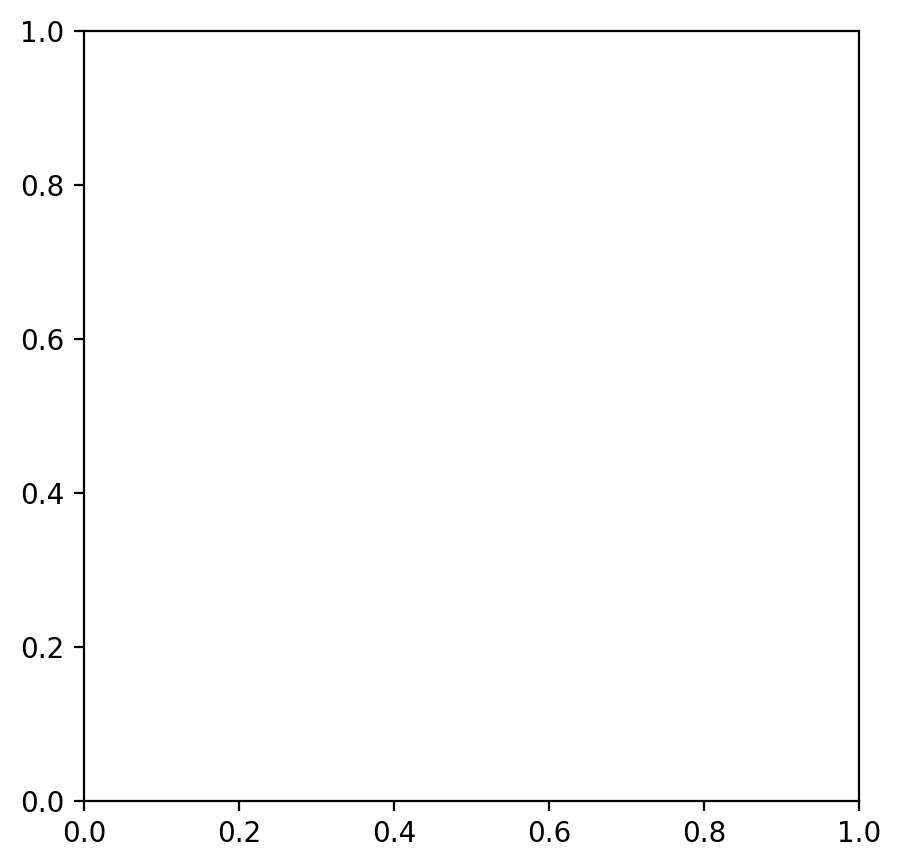

In [6]:
# Create a colormap from blue to red
fig = plt.figure(figsize=(5, 5), dpi=200)
# Define the colors: white for land and light blue for water
ax = plt.axes()
# Plot the land mask
#ax.scatter(lon.ravel(), lat.ravel(), marker=".", s=0.01, c=land_mask)
ax.pcolormesh(lon, lat, land_mask, cmap=custom_cmap, shading='auto')
# Plot initial and final positions
ax.scatter(IC[1,:], IC[0, :], label="IC", c="blue", s=0.5)
# Set axis labels and legend
ax.set_xlim(lon_min - 0.05 * (lon_max - lon_min), lon_max + 0.05 * (lon_max - lon_min))
ax.set_ylim(lat_min - 0.05 * (lat_max - lat_min), lat_max + 0.05 * (lat_max - lat_min))
ax.set_xlabel("Rotated Longitude")
ax.set_ylabel("Rotated Latitude")
# Remove duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.15), fancybox=True)
plt.savefig(results_directory+'/IC.png')

In [7]:


### Plot some of the advected trajectories
print("Ploting the advected trajectories")

DFDt = DFDt[:-1,:,:]
# Trajectories which velocities vanish to zero
nulvel_trajectories_idx = np.unique(np.where((abs(DFDt[:-1,0,:]) < 1e-8) & (abs(DFDt[:-1,1,:]) < 1e-8))[1])

"""
velocity_threshold = 0.1
# Check if the velocity is below the threshold for all time steps
condition_x = np.all(abs(DFDt[:, 0, :]) < velocity_threshold, axis=0)
condition_y = np.all(abs(DFDt[:, 1, :]) < velocity_threshold, axis=0)
# Combine conditions for both x and y components
condition = condition_x & condition_y
# Get the indices of trajectories that satisfy the condition
nulvel_trajectories_idx = np.where(condition)[0]

print("The number of trajectories with constant slow velocity is "+str(len(nulvel_trajectories_idx)))


#Delete trajectories with vanishing velocities
Fmap_filtered = np.delete(Fmap,nulvel_trajectories_idx,axis=2)
DFDt_filtered = np.delete(DFDt,nulvel_trajectories_idx,axis=2)
"""



Ploting the advected trajectories


'\nvelocity_threshold = 0.1\n# Check if the velocity is below the threshold for all time steps\ncondition_x = np.all(abs(DFDt[:, 0, :]) < velocity_threshold, axis=0)\ncondition_y = np.all(abs(DFDt[:, 1, :]) < velocity_threshold, axis=0)\n# Combine conditions for both x and y components\ncondition = condition_x & condition_y\n# Get the indices of trajectories that satisfy the condition\nnulvel_trajectories_idx = np.where(condition)[0]\n\nprint("The number of trajectories with constant slow velocity is "+str(len(nulvel_trajectories_idx)))\n\n\n#Delete trajectories with vanishing velocities\nFmap_filtered = np.delete(Fmap,nulvel_trajectories_idx,axis=2)\nDFDt_filtered = np.delete(DFDt,nulvel_trajectories_idx,axis=2)\n'

In [9]:
print("The number of trajectories with constant slow velocity is "+str(len(nulvel_trajectories_idx)))


#Delete trajectories with vanishing velocities
Fmap_filtered = np.delete(Fmap,nulvel_trajectories_idx,axis=2)
DFDt_filtered = np.delete(DFDt,nulvel_trajectories_idx,axis=2)

The number of trajectories with constant slow velocity is 252


In [12]:
Fmap_filtered=Fmap

/tmp/ipykernel_3039504/1554485641.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(lon, lat, land_mask, cmap=custom_cmap, shading='auto')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

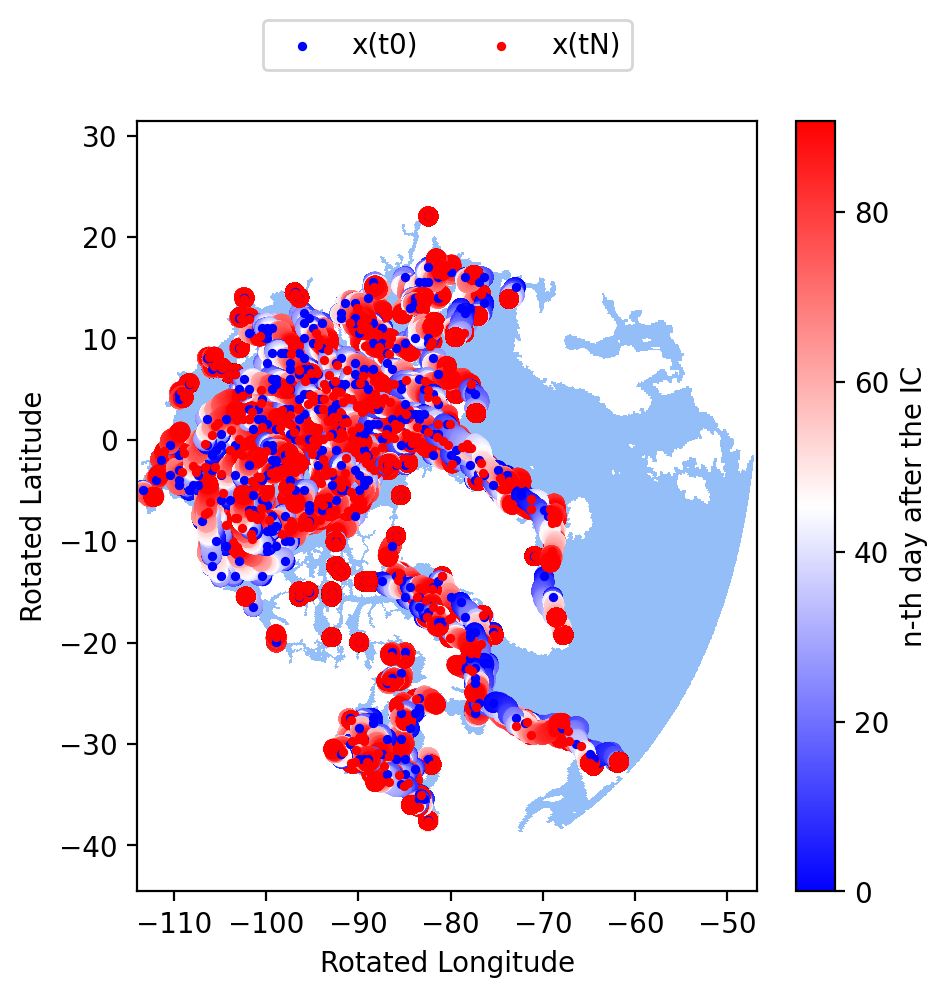

In [13]:
# Assuming Fmap_filtered is a 3D numpy array with shape (n, 2, m)
n, _, m = Fmap_filtered.shape
ntraj_filter = 10
random_indices = np.random.choice(m, size=m // ntraj_filter, replace=False)
# Filter Fmap using the randomly selected indices
Fmap_filtered = Fmap_filtered[:, :, random_indices]
# Create a colormap from blue to red
cmap = plt.get_cmap('bwr', n)
# Create a figure
fig = plt.figure(figsize=(5, 5), dpi=200)
# Define the colors: white for land and light blue for water
colors = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors)
land_colors = plt.get_cmap(custom_cmap, 2)
ax = plt.axes()
# Plot the land mask
#ax.scatter(lon_grid.ravel(), lat_grid.ravel(), marker=".", s=0.1, c=regrided_land_mask, cmap=land_colors)
ax.pcolormesh(lon, lat, land_mask, cmap=custom_cmap, shading='auto')
# Plot trajectories with color gradient based on time
n, _, m = Fmap_filtered.shape
for j in range(m):
    print(j)
    # Extract the x and y coordinates for the trajectory
    x = Fmap_filtered[:, 0, j]
    y = Fmap_filtered[:, 1, j]
    
    # Create a color array for the trajectory
    colors = [cmap(i) for i in range(n - 1)]
    
    # Scatter plot for each segment of the trajectory
    ax.scatter(x[:-1], y[:-1], color=colors)
# Plot initial and final positions
ax.scatter(Fmap_filtered[0, 0, :], Fmap_filtered[0, 1, :], label="x(t0)", c="blue", s=5.5)
ax.scatter(Fmap_filtered[-1, 0, :], Fmap_filtered[-1, 1, :], label="x(tN)", c="red", s=5.5)
# Set axis labels
ax.set_xlabel("Rotated Longitude")
ax.set_ylabel("Rotated Latitude")
# Add a color bar
norm = plt.Normalize(vmin=0, vmax=(n-1)/10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for older versions of matplotlib
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('n-th day after the IC')
# Remove duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.15), fancybox=True)
# Save the plot
plt.savefig(results_directory+'/Advected_trajectories.png')